# Importing libs

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import time
from tabulate import tabulate
import scipy.optimize as optimize
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

# Settings

In [2]:
# Assets 
assets = [
    'VVAR3.SA',
    #'NTCO3.SA',
    #'BPAN4.SA',
    'WEGE3.SA',
    #'LWSA3.SA',
    'ITSA4.SA',
    #'FLRY3.SA',
    #'LREN3.SA',
    'MGLU3.SA',
#    'QCOM34.SA'
]

## NUMBER OF ASSETS
n_assets = len(assets)

## NUMBER OF OBSERVATIONS
n_obs = 30000

# Risk Free Rate
risk_free_rate = 0.02

#Get the stock starting date
stockStartDate = '2015-01-01'

# Get the stocks ending date aka todays date and format it in the form YYYY-MM-DD
today = datetime.today().strftime('%Y-%m-%d')

# Reading data

In [3]:
#Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

#Store the adjusted close price of stock into the data frame
for stock in assets:
    df[stock.split('.')[0]] = web.DataReader(
        stock,data_source='yahoo',
        start=stockStartDate ,
        end=today
    )['Adj Close']

In [4]:
df.tail()

,VVAR3,WEGE3,ITSA4,MGLU3
Date,,,,
2021-01-06,15.49,81.300003,11.69,23.459999
2021-01-07,15.08,84.660004,12.16,23.160000
2021-01-08,15.58,89.779999,12.13,23.840000
2021-01-11,15.08,87.739998,11.90,23.510000
2021-01-12,15.17,90.070000,11.94,24.200001


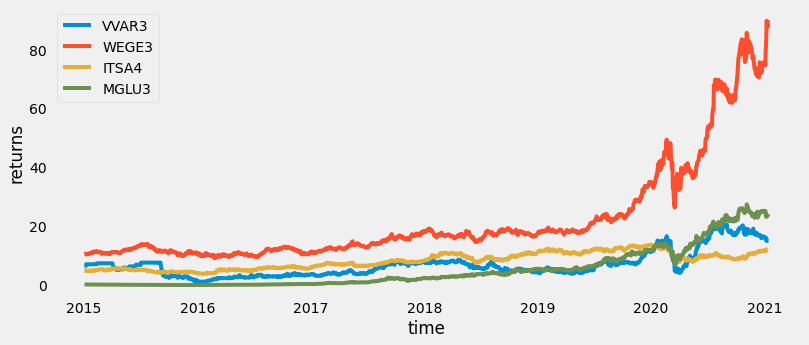

In [5]:
fig = plt.figure(figsize=(12,5))
plt.plot(df)
plt.xlabel('time')
plt.ylabel('returns')
plt.legend(df.columns.tolist())
plt.grid()

# Let's simulate some portfolios

In [6]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

rand_weights(n_assets)

array([0.26567654, 0.16811212, 0.23343237, 0.33277897])

In [7]:
def portfolio_simulation(df, iterations):
    '''
    Runs a simulation by randomly selecting portfolio weights a specified
    number of times (iterations), returns the list of results and plots 
    all the portfolios as well.
    
    Parameters:
    -----------  
        assets: list
            all the assets that are to be pulled from Quandl to comprise
            our portfolio.    
        iterations: int 
            the number of randomly generated portfolios to build.
    
    Returns:
    --------
        port_returns: array
            array of all the simulated portfolio returns.
        port_vols: array
            array of all the simulated portfolio volatilities.
    '''
    start = time.time()
    
    # Getting returns
    returns = df.pct_change()
    
    port_returns = []
    port_vols = []
    
    for i in range (iterations):
        # Generating random weights using dirichlet distribution
        weights = rand_weights(n_assets)
        
        # Returns: R = pt.w
        port_return = np.sum(returns.mean() * weights) * 252
        port_returns.append(port_return)
        
        # Volatility: sigma = sqrt( wt.C.w )
        port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        port_vols.append(port_vol)
    
    # Convert lists to arrays
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)
 
    
    # Plot the distribution of portfolio returns and volatilities 
    plt.figure(figsize = (12,6))
    plt.scatter(port_vols, port_returns,c = (port_returns / port_vols), marker='o')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.grid()
    plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')
    
    print('Elapsed Time: %.2f seconds' % (time.time() - start))
    
    return port_returns, port_vols

Elapsed Time: 28.03 seconds


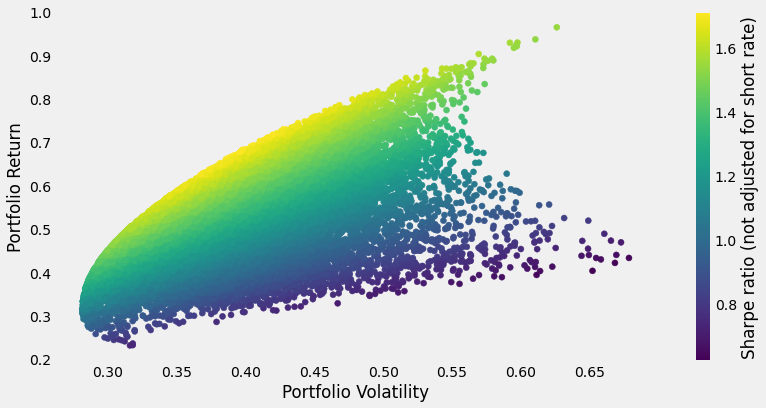

In [8]:
port_returns, port_vols = portfolio_simulation(df, n_obs)

# Generating stats to optimize

In [9]:
returns = df.pct_change()
returns.head()

,VVAR3,WEGE3,ITSA4,MGLU3
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,0.000000,0.006818,0.003271,0.018792
2015-01-06,0.000000,-0.014834,0.007609,-0.013175
2015-01-07,0.082353,-0.011457,0.037756,0.033380
2015-01-08,0.000000,0.016887,0.010395,-0.007752


In [10]:
def portfolio_stats(weights):
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, sharp ratio.
    '''
    # random weights generated by optimization function
    weights = np.array(weights)
    
    # Returns: R = pt.w
    port_return = np.sum(returns.mean() * weights) * 252
    
    # Volatility: sigma = sqrt( wt.C.w )
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Sharpe ratio
    sharpe = (port_return - risk_free_rate)/port_vol

    return {'return': port_return, 'volatility': port_vol, 'sharpe': sharpe}

In [11]:
def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

In [12]:
def minimize_volatility(weights):  
    return portfolio_stats(weights)['volatility'] 

In [13]:
def minimize_return(weights): 
    return -portfolio_stats(weights)['return']

# Optimization process

In [14]:
def optimize_portfolio(func_to_optimize, constraints, bounds, initializer):
    
    # Optimizing for given function
    optimal_result = optimize.minimize(
        fun = func_to_optimize,
        x0 = initializer,
        method = 'SLSQP',
        bounds = bounds,
        constraints = constraints
    )
    
    # Getting optimal weights for each asset
    optimal_weights = optimal_result['x'].round(4)
    print('Optimal weights by asset:')
    print(tabulate(list(zip(assets,list(optimal_weights)))))
    
    # Getting optimal portfolio stats
    optimal_stats = portfolio_stats(optimal_weights)
    print('-'*80)
    print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
    print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
    print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))
    
    return optimal_result, optimal_weights, optimal_stats

In [15]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0.1,1) for x in range(n_assets))
initializer = n_assets * [1./n_assets,]

In [16]:
results_sharpe, weights_sharpe, stats_sharpe = optimize_portfolio(minimize_sharpe, constraints, bounds, initializer)

Optimal weights by asset:
--------  ----
VVAR3.SA  0.1
WEGE3.SA  0.39
ITSA4.SA  0.1
MGLU3.SA  0.41
--------  ----
--------------------------------------------------------------------------------
Optimal Portfolio Return:  64.2953
Optimal Portfolio Volatility:  38.7729
Optimal Portfolio Sharpe Ratio:  1.6067


In [17]:
results_return, weights_return, stats_return = optimize_portfolio(minimize_return, constraints, bounds, initializer)

Optimal weights by asset:
--------  ---
VVAR3.SA  0.1
WEGE3.SA  0.1
ITSA4.SA  0.1
MGLU3.SA  0.7
--------  ---
--------------------------------------------------------------------------------
Optimal Portfolio Return:  81.3227
Optimal Portfolio Volatility:  51.8006
Optimal Portfolio Sharpe Ratio:  1.5313


In [18]:
results_risk, weights_risk, stats_risk = optimize_portfolio(minimize_volatility, constraints, bounds, initializer)

Optimal weights by asset:
--------  ------
VVAR3.SA  0.1
WEGE3.SA  0.3432
ITSA4.SA  0.4568
MGLU3.SA  0.1
--------  ------
--------------------------------------------------------------------------------
Optimal Portfolio Return:  38.3801
Optimal Portfolio Volatility:  29.3272
Optimal Portfolio Sharpe Ratio:  1.2405


# The Efficient Frontier

In [19]:
# Make an array of 50 returns betweeb the minimum return and maximum return
# discovered earlier.
target_returns = np.linspace(port_returns.min(),port_returns.max(),50)

# Initialize optimization parameters
minimal_volatilities = []
bounds = tuple((0,1) for x in range(n_assets))
initializer = n_assets * [1./n_assets,]

for target_return in target_returns:
    
    constraints = ({'type':'eq','fun': lambda x: portfolio_stats(x)['return']-target_return},
                   {'type':'eq','fun': lambda x: np.sum(x)-1})
       
    optimal = optimize.minimize(minimize_volatility,
                              initializer,
                              method = 'SLSQP',
                              bounds = bounds,
                              constraints = constraints)
    
    minimal_volatilities.append(optimal['fun'])

minimal_volatilities = np.array(minimal_volatilities)

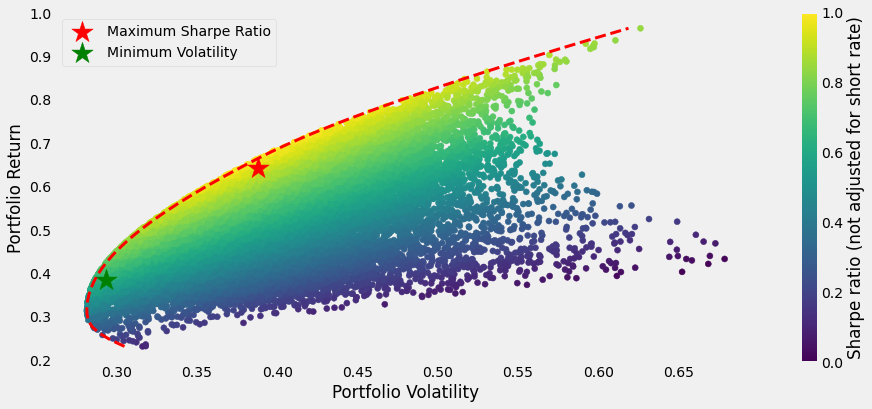

In [20]:
# initialize figure size
plt.figure(figsize=(14,6))

# Plotting portfolios
plt.scatter(port_vols,
            port_returns,
            c = (port_returns / port_vols),
            marker = 'o')

# Plotting minimal volatility point
plt.plot(minimal_volatilities, target_returns,'r--', linewidth=3)

plt.scatter(portfolio_stats(weights_sharpe)['volatility'],
            portfolio_stats(weights_sharpe)['return'],
            marker = '*', color='r', s=500, label='Maximum Sharpe Ratio')

plt.scatter(portfolio_stats(weights_risk)['volatility'],
            portfolio_stats(weights_risk)['return'],
            marker = '*', color='g', s=500, label='Minimum Volatility')

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.grid()
plt.legend()
plt.colorbar(label='Sharpe ratio (not adjusted for short rate)')